# Maximin Affinity Learning of Image Segmentation (MALIS)

In this notebook, we will implement the following paper:
> [*Maximin affinity learning of image segmentation*, Srinivas C. Turaga et al. Advances in Neural Information Processing Systems, 2009](http://papers.nips.cc/paper/3887-maximin-affinity-learning-of-image-segmentation)

We tried to be as faithful as possible to the original implementation, but since some information were absent (e.g. optimizer used, which probably was SGD) we had to guess what was used.
We also used some more recent improvements, either in the neural network or in the maximin computation. 

We also used the following thesis to help us in our implementation, as it gives a bit more clarity on some steps of the process.
> [*Learning image segmentation and hierarchies by learning ultrametric distances*, Srinivas C. Turaga, 2009.](https://dspace.mit.edu/handle/1721.1/54626)

In [0]:
!nvidia-smi

Sat Jan 18 23:32:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    35W / 250W |    739MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%%capture
!pip install ipywidgets
!pip install higra

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import h5py

import higra as hg
from higra import HorizontalCutExplorer,HorizontalCutNodes, CptHierarchy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

In [0]:
EPOCHS = 100
BATCH_SIZE = 1 
LEARNING_RATE = 1e-4
BETA_1 = 0.9
BETA_2 = 0.99
PATCH_SIZE = 21
N_PAIRS = 8

# Dataset

In this example, we use the [CREMI](https://cremi.org/data/) dataset, and will load directly the hdf file into a PyTorch dataset.

In [0]:
class CREMIDataset(Dataset):
    """CREMI Dataset"""

    def __init__(self, hdf_file, img_dir, seg_dir, transform=None):
        """
        Args:
            hdf_file (string): Path to the hdf file with the data.
            img_dir (string): Directory with all the images.
            seg_dir (string): Directory with all the associated segmentation.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.hdf = h5py.File(hdf_file, 'r')
        self.img_dir = img_dir
        self.seg_dir = seg_dir
        self.transform = transform
        self.image_shape = self.hdf[self.img_dir][0].shape

    def __len__(self):
        return self.hdf[self.img_dir].shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #Fuse all ndarrays into one and normalize
        image = np.stack([self.hdf[self.img_dir][idx]],axis=0)/255
        #Change type since original type (uint64) is not supported
        segment = np.stack(self.hdf[self.seg_dir][idx],axis=0).astype(np.int64)

        sample = {'image': image, 'segmentation': segment}

        if self.transform:
            sample = self.transform(sample)

        return sample

This function will be used to obtain all NxN patches in an image. (21x21 in our case)

The parameter *stride* will be used to get overlapping images. A stride of M will give us an overlap of N-M between our patches

In [0]:
def get_patches_from_image(image,gt_image, patch_size, stride=None):
  if stride == None:
    stride = patch_size
  n_patches = (image.shape[1]-patch_size)//stride + 1
  patches = []
  for i in range(0,image.shape[1]-patch_size,stride):
    for j in range(0,image.shape[1]-patch_size,stride):
        uniques,counts = np.unique(gt_image[...,i:i+patch_size,j:j+patch_size],return_counts=True)
        #Can reduce X in the condition 'count > X' by modfiying pair generation
        if len([unique for i,unique in enumerate(uniques) if counts[i] > 2*N_PAIRS])> 2:
          patches.append(image[...,i:i+patch_size,j:j+patch_size])
  return patches

In [0]:
filename = 'sample_A_20160501.hdf' 
dataset = CREMIDataset(filename,'volumes/raw','volumes/labels/neuron_ids')

In [0]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True, num_workers=1)

# CNN architecture

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.relu = nn.ReLU()
    self.conv1 = nn.Conv2d(1,8,5, padding=2) #padding = (kernel-1)/2
    self.conv1_bn = nn.BatchNorm2d(8)
    self.conv2 = nn.Conv2d(8,32,5, padding=2)
    self.conv2_bn = nn.BatchNorm2d(32)
    self.conv3 = nn.Conv2d(32,32,5, padding=2)
    self.conv3_bn = nn.BatchNorm2d(32)
    self.conv4 = nn.Conv2d(32,32,5, padding=2)
    self.conv4_bn = nn.BatchNorm2d(32)
    self.conv5 = nn.Conv2d(32,8,5, padding=2)
    self.conv5_bn = nn.BatchNorm2d(8)
    self.conv6 = nn.Conv2d(8,2,5, padding=2)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    x = self.relu(self.conv1_bn(self.conv1(x)))
    x = self.relu(self.conv2_bn(self.conv2(x)))
    x = self.relu(self.conv3_bn(self.conv3(x)))
    x = self.relu(self.conv4_bn(self.conv4(x)))
    x = self.relu(self.conv5_bn(self.conv5(x)))
    x = self.sigmoid(self.conv6(x))

    return x


net = Net().to(device)
print(net)
summary(net, (1,21,21))

Net(
  (relu): ReLU()
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(8, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (sigmoid): Sigmoid()
)
-----------------------------

# Graph reconstruction
This function is used to get the graph corresponding to our NN output.
  * *edge_values_x[i]* is the value of the edge from i to it's right neigbour
  * *edge_values_y[i]* is the value of the edge from i to it's top neigbour

In [0]:
def get_graph_from_image(edge_values_x, edge_values_y,plot=False):
  
  image_size = edge_values_x.shape
  #Dimensionality reduction
  if edge_values_x.ndim > 1:
    edge_values_x = edge_values_x.flatten()
  if edge_values_y.ndim > 1:
    edge_values_y = edge_values_y.flatten()
  
  #Graph creation
  g = hg.get_4_adjacency_graph(image_size)

  #weighting function
  def weight_fn(i, j):
    im = min(i,j)
    jm = max(i,j)
    if jm-im == image_size[0]: 
      #We have two pixel on top of each other
      return edge_values_y[jm]
    else:
      return edge_values_x[im]

  # Computing weights
 
  edge_w = hg.weight_graph_function(g,weight_fn)
  if plot :
    plt.imshow(hg.graph_4_adjacency_2_khalimsky(g, 1-edge_w.detach().numpy()),cmap="gray")

  return g, edge_w
  

# Maximin

To calculate the maximin edge value for two distinct vertices, we will use a binary partition tree as described in [Playing with Kruskal: algorithms formorphological trees in edge-weighted graphs](https://hal.archives-ouvertes.fr/hal-00798621/) which will give us increased performances over a simple MST with a breadth first search between our vertices, especially if we want to use multiple pairs our vertices.

In [0]:
def get_random_pairs(gt, n_pairs):
  if gt.ndim > 1:
    gt = gt.flatten()
  #Finding 2 random regions (All patches must have at least 2)
  rgs,count = np.unique(gt,return_counts=True)
  # Filtering regions with not enough pixels for all pairs
  regions = np.array([rg for i,rg in enumerate(rgs) if count[i] > 2*n_pairs])
  rnd_reg = np.random.choice(regions,2,replace=False)
  indices_1 =np.argwhere(gt==rnd_reg[0]).flatten()
  indices_2 = np.argwhere(gt==rnd_reg[1]).flatten()
  
  pairs_intra = np.random.choice(indices_1,(n_pairs,2),replace=False)

  pairs_inter_1 = np.random.choice(indices_1,(n_pairs,1),replace=False)
  pairs_inter_2 = np.random.choice(indices_2,(n_pairs,1),replace=False)
  pairs_inter = np.hstack((pairs_inter_1,pairs_inter_2))
  return (pairs_inter, pairs_intra)

In [0]:
def get_maximin_edge(graph, edge_weights, rand_pairs):
  # get maximin between vertices at index v1 and v2
  tree, altitudes = hg.bpt_canonical(graph, -edge_weights/255)
  lcaf = hg.make_lca_fast(tree)
  
  #Get edge
  mst = hg.get_attribute(tree,"mst")
  mst_map =hg.get_attribute(mst,"mst_edge_map")
  mst_idcs = lcaf.lca(*rand_pairs.T) - tree.num_leaves()
  edge_idcs = mst_map[mst_idcs]
  return np.array([graph.edge_from_index(edge_idx)[:2] for edge_idx in edge_idcs])

# Loss and optimizer

In [0]:
def indicator_fn(gt_image, rand_pairs):
  im = gt_image.flatten()
  t = torch.tensor([1 if im[pair[0]] == im[pair[1]] else 0 for pair in rand_pairs],device=device,dtype=torch.float)
  return t

In [0]:
def nn_loss(gt_image, pred, rand_pairs, margin=0.3):
  #rand_pair tuple
  x = indicator_fn(gt_image, rand_pairs)
  #print("Preds :",pred)
  #print("Truth :", x)
  loss = x*torch.relu(1-pred-margin)**2+(1-x)*torch.relu(pred - margin)**2
  #print("Loss :",loss)
  loss = torch.mean(loss)
  return loss

In [0]:
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))

# Training

In [0]:
# This function is used to debug autograd
def print_hist(tensor,depth=10):
    grad = tensor.grad_fn
    print("Historique du gradient:\n",grad.name())
    grad = grad.next_functions[0][0]
    i = 0
    while grad is not None and i < depth:
        print(grad.name())
        grad = grad.next_functions[0][0]


In [0]:
criterion = torch.nn.MSELoss()
losses=[]
it = 0

In [0]:

start=time.time()
for epoch in range(EPOCHS): 
  #For each image in the dataset
  for i,image in enumerate(dataloader):
    gt_patches = get_patches_from_image(image["segmentation"][0],image["segmentation"][0],PATCH_SIZE)
    for j,patch in enumerate(get_patches_from_image(image["image"][0],image["segmentation"][0],PATCH_SIZE)):
      net.zero_grad()

      #Creating a batch of one for our input
      input_im = torch.stack([patch])
      input_im = input_im.to(device,dtype=torch.float)


      #Making predictioms
      output = net(input_im)
      output_x = output[0,0,:,:]
      output_y = output[0,1,:,:]

      # Retrieving the maximin edge using Higra
      #TODO : modify this part since it is not currently working if we use the cpu
      if device.type == "cuda" :
        output_x_cpu = output_x.to("cpu")
        output_y_cpu = output_y.to("cpu")

      g,edge_weights = get_graph_from_image(output_x_cpu, output_y_cpu)
      pairs_inter, pairs_intra = get_random_pairs(gt_patches[j],N_PAIRS)
      pairs  = np.concatenate((pairs_inter,pairs_intra))
    
      mm_edges = get_maximin_edge(g,edge_weights,pairs)

      #Find the maximin edges in our outputs
      ims = np.amin(mm_edges,axis=1)
      jms = np.amax(mm_edges,axis=1)
      mm_values = torch.stack([output_y.flatten()[jm] if jm-im == PATCH_SIZE else output_x.flatten()[im] for im,jm in zip(ims,jms)])
      #Computing the loss fucntion
      
      truth = indicator_fn(gt_patches[j],pairs)
      loss = criterion(mm_values,truth)
      #loss = criterion(gt_patches[j],mm_values,pairs,0)
      losses.append(loss.clone().detach().cpu().numpy())
      """
      #Debug autograd by printing history of a variable
      hist = mm_values[0]
      print(hist)
      print_hist(hist)
      print("=======================")
      """
      # Updating weights
      loss.backward()
      optimizer.step()
      it +=1
      if it % 1000 == 0:
        print(it,"th iteration, avg loss: ", np.mean(losses[it-1000:it-1]), "time taken: ",time.time()-start,"seconds" )
        start= time.time()



KeyboardInterrupt: ignored

In [0]:
torch.save(net.state_dict(), "./model_bn.pt")
np.save("loss_bn.npy", np.array(losses))

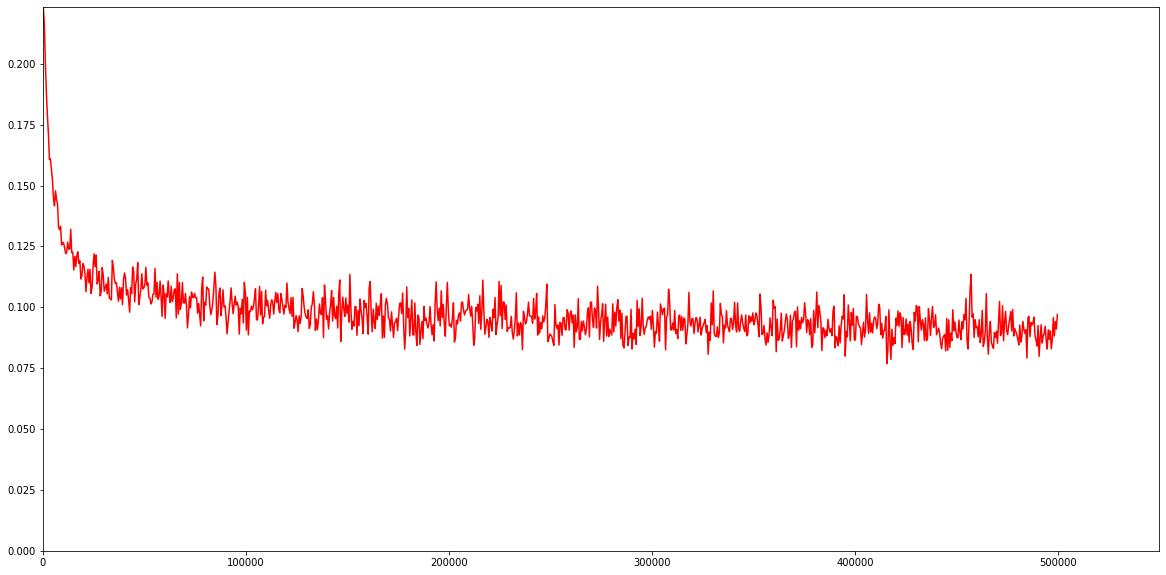

In [0]:
samples =500 
loss_sampled = []
xs = []
plt.figure(figsize=(20,10))
for i in range(len(losses) // samples):
    loss_sampled.append(np.mean(losses[i*samples:(i+1)*samples]))
    xs.append(i*samples + samples/2)

plt.plot(xs, loss_sampled, "r-")

plt.xlim([0, xs[-1] + xs[-1]*0.1])
plt.ylim([0, np.max(loss_sampled)])

plt.show()

# Tests

In [0]:
gt_patches = get_patches_from_image(dataset[0]["segmentation"],dataset[0]["segmentation"],PATCH_SIZE)
im_patches = get_patches_from_image(dataset[0]["image"],dataset[0]["segmentation"],PATCH_SIZE)

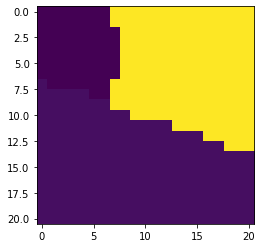

In [0]:
plt.imshow(gt_patches[19])

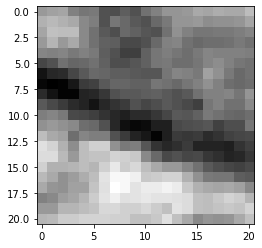

In [0]:
plt.imshow(im_patches[19][0],cmap="gray")

In [0]:
input_im = torch.tensor(im_patches[19])
input_im = torch.stack([input_im])
input_im = input_im.to(device,dtype=torch.float)
pred = net(input_im)

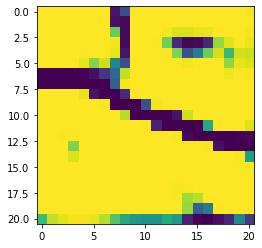

In [0]:
plt.imshow(pred[0][0].cpu().detach().numpy())

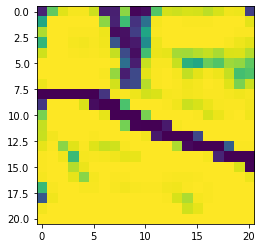

In [0]:
plt.imshow(pred[0][1].cpu().detach().numpy())